In [1]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from functools import reduce
import time

# Set a nice style for the plots
sns.set_theme(style="whitegrid")
print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# %%
import os

def get_figures_path():
    target_suffix = os.path.join("Contrastive_Learning", "code", "ML_model", "figures")
    cwd = os.path.abspath(os.getcwd())
    parts = cwd.split(os.sep)
    for i in range(len(parts), 0, -1):
        candidate = os.sep.join(parts[:i])
        test_path = os.path.join(candidate, target_suffix)
        if os.path.isdir(test_path):
            return test_path
    raise FileNotFoundError(f"Path ending with '{target_suffix}' not found")


# --- Logit transformation function ---
def logit(p: pd.Series) -> pd.Series:
    """Converts PSI (0-1) to logit."""
    # Clip for numerical stability to avoid log(0) or log(1)
    p = p.clip(1e-6, 1.0 - 1e-6)
    return np.log(p / (1 - p))

# --- REVISED: Calculates delta-logit from wide PSI DataFrames ---
def get_delta_psi_logit(df: pd.DataFrame, tissue_cols: list, gt_df_full: pd.DataFrame) -> (pd.DataFrame, list):
    """
    Calculates delta-logit for a given wide DataFrame 'df' (predictions or GT)
    by aligning with the logit_mean_psi from the full ground truth 'gt_df_full'.
    Handles potential column name conflicts during merge.
    """
    # Ensure exon_id is present
    if 'exon_id' not in df.columns:
        raise ValueError("Input DataFrame 'df' must contain 'exon_id' column.")
    if 'exon_id' not in gt_df_full.columns:
         raise ValueError("Ground truth DataFrame 'gt_df_full' must contain 'exon_id' column.")
    if 'logit_mean_psi' not in gt_df_full.columns:
         raise ValueError("Ground truth DataFrame 'gt_df_full' must contain 'logit_mean_psi' column.")

    # Select only the necessary columns from ground truth for the merge
    gt_subset_for_merge = gt_df_full[['exon_id', 'logit_mean_psi']].copy()

    # Define potential suffixes
    suffix_original = '_original_df'
    suffix_from_gt = '_from_gt_df'

    # Perform the merge
    merged_df = pd.merge(
        df,
        gt_subset_for_merge,
        on='exon_id',
        how='left',
        suffixes=(suffix_original, suffix_from_gt)
    )

    # --- Determine the correct ground truth logit_mean_psi column name ---
    gt_logit_mean_col = 'logit_mean_psi'
    if f'logit_mean_psi{suffix_from_gt}' in merged_df.columns:
        gt_logit_mean_col = f'logit_mean_psi{suffix_from_gt}'
    elif 'logit_mean_psi' not in merged_df.columns:
        raise KeyError("Could not find the 'logit_mean_psi' column after merging.")

    # Handle cases where predictions are for exons not in gt_df
    if merged_df[gt_logit_mean_col].isnull().any():
        missing_count = merged_df[gt_logit_mean_col].isnull().sum()
        print(f"Warning: Found {missing_count} exons in input 'df' not found in ground truth. They will be dropped.")
        merged_df = merged_df.dropna(subset=[gt_logit_mean_col])
        if merged_df.empty:
             raise ValueError("After merging and dropping missing ground truth, the DataFrame is empty.")

    # Convert only the specified tissue columns to numeric
    psi_df = merged_df[tissue_cols].apply(pd.to_numeric, errors='coerce')

    # Detect if PSI values are given as percentages (> 1.5)
    if not psi_df.empty and (psi_df.max(skipna=True).max(skipna=True) > 1.5):
        print("Detected PSI values > 1.5, converting from 0-100 scale.")
        psi_df = psi_df / 100.0
    elif psi_df.empty:
         print("Warning: No valid PSI values found to process after filtering/conversion.")
         empty_delta_logit = pd.DataFrame(columns=['exon_id'] + tissue_cols)
         return empty_delta_logit, tissue_cols


    # Compute logit(PSI) for each tissue
    logit_psi_df = psi_df.apply(logit)

    # Subtract the correctly identified ground truth logit_mean_psi
    delta_logit_df = logit_psi_df.sub(merged_df[gt_logit_mean_col], axis=0)

    # Add the exon_id column back
    delta_logit_df['exon_id'] = merged_df['exon_id']

    # Ensure exon_id is the first column for consistency
    delta_logit_df = delta_logit_df[['exon_id'] + tissue_cols]

    return delta_logit_df, tissue_cols

In [3]:
# %%
# --- Loads and processes the ground truth PSI file ---
def load_ground_truth(filepath: str) -> (pd.DataFrame, list):
    """
    Loads the ground truth PSI CSV file and returns the
    wide DataFrame and the list of tissue columns.
    """
    print(f"Loading and processing Ground Truth from: {filepath}")
    df = pd.read_csv(filepath)
    
    # This column indexing is from your script
    meta_cols = [
        'exon_id', 'cassette_exon', 'alternative_splice_site_group', 'linked_exons',
        'mutually_exclusive_exons', 'exon_strand', 'exon_length', 'gene_type',
        'gene_id', 'gene_symbol', 'exon_location', 'exon_boundary',
        'chromosome', 'mean_psi', 'logit_mean_psi'
    ]
    tissue_cols = [col for col in df.columns if col not in meta_cols]
    
    # --- NEW: Ensure PSI values are 0-1 ---
    # Check if max PSI is > 1.5, indicating 0-100 scale
    if not df[tissue_cols].empty and (df[tissue_cols].max(skipna=True).max(skipna=True) > 1.5):
        print("Ground Truth: Detected PSI values > 1.5, converting from 0-100 scale.")
        df[tissue_cols] = df[tissue_cols] / 100.0
    
    return df, list(tissue_cols)


# --- MODIFIED: Loads single run *PSI predictions* ---
def load_single_run_predictions(results_folder: str, run_name: str=None) -> (pd.DataFrame, list):
    """
    Loads the raw PSI predictions for a single run
    and returns a wide DataFrame and the list of tissue columns.
    """
    if run_name is None:
        filepath = Path(results_folder) / 'tsplice_final_predictions_all_tissues.tsv'
    else:
        filepath = Path(results_folder) / run_name / 'tsplice_final_predictions_all_tissues.tsv'
    if not filepath.exists():
        raise FileNotFoundError(f"Prediction file not found at: {filepath}")
        
    print(f"Loading single run PSI predictions from: {filepath}")
    
    df = pd.read_csv(filepath, sep='\t')
    
    # This column indexing is from your script
    pred_cols = df.columns[1:]
    
    # --- NEW: Ensure PSI values are 0-1 ---
    if not df[pred_cols].empty and (df[pred_cols].max(skipna=True).max(skipna=True) > 1.5):
        print(f"Predictions ({run_name}): Detected PSI values > 1.5, converting from 0-100 scale.")
        df[pred_cols] = df[pred_cols] / 100.0
    
    return df, list(pred_cols)

In [4]:
# %%
# --- NEW: Generic RMSE Calculation Function ---
def calculate_rmse_by_tissue(
    pred_df: pd.DataFrame, 
    gt_df: pd.DataFrame, 
    gt_col: str, 
    pred_col: str, 
    rmse_col_name: str
) -> pd.DataFrame:
    """
    Calculates the RMSE for each tissue given long-format dataframes.
    
    Args:
        pred_df (pd.DataFrame): Long-format DF with ['exon_id', 'tissue', pred_col]
        gt_df (pd.DataFrame): Long-format DF with ['exon_id', 'tissue', gt_col]
        gt_col (str): Column name for ground truth values (e.g., 'gt_psi')
        pred_col (str): Column name for predicted values (e.g., 'pred_psi')
        rmse_col_name (str): Desired output column name (e.g., 'rmse_psi')
        
    Returns:
        pd.DataFrame: ['tissue', rmse_col_name]
    """
    # Merge predictions and ground truth
    merged_df = pd.merge(gt_df, pred_df, on=['exon_id', 'tissue'])
    
    # Handle missing values if any
    merged_df = merged_df.dropna(subset=[gt_col, pred_col])
    
    if merged_df.empty:
        print(f"Warning: No overlapping data found for columns {gt_col} and {pred_col}. Returning empty RMSE df.")
        return pd.DataFrame(columns=['tissue', rmse_col_name])
    
    # Calculate squared error
    merged_df['sq_error'] = (merged_df[gt_col] - merged_df[pred_col]) ** 2
    
    # Calculate MSE per tissue
    tissue_mse = merged_df.groupby('tissue')['sq_error'].mean()
    
    # Calculate RMSE per tissue
    tissue_rmse = np.sqrt(tissue_mse).reset_index(name=rmse_col_name)
    
    return tissue_rmse

In [5]:
# %%
# --- Plotting functions (no change) ---
def _prepare_single_model_df(df, metric, model_name):
    """Internal helper to prepare one DataFrame for comparison."""
    is_averaged = f'mean_{metric}' in df.columns
    metric_col = f'mean_{metric}' if is_averaged else metric
    std_col = f'std_{metric}' if is_averaged else None
    
    if metric_col not in df.columns:
        raise KeyError(f"Metric column '{metric_col}' not found in DataFrame. Available: {df.columns.tolist()}")
        
    cols_to_select = ['tissue', metric_col]
    if is_averaged and std_col and std_col in df.columns:
        cols_to_select.append(std_col)
    
    plot_df = df[cols_to_select].copy()
    plot_df.rename(columns={metric_col: model_name}, inplace=True)
    return plot_df

def prepare_grouped_plot_data(df1, df2, metric, model1_name, model2_name):
    """
    Prepares and merges data from two models for a grouped bar plot.
    """
    model1_plot_df = _prepare_single_model_df(df1, metric, model1_name)
    model2_plot_df = _prepare_single_model_df(df2, metric, model2_name)
    
    comparison_df = pd.merge(model1_plot_df, model2_plot_df, on='tissue', how='inner')
    
    melted_df = comparison_df.melt(id_vars='tissue', value_vars=[model1_name, model2_name], 
                                   var_name='Model', value_name=metric) # Use metric for y-axis
    
    return comparison_df, melted_df

In [6]:
# %%
def plot_grouped_comparison(comparison_df, melted_df, title, model1_name, model2_name, y_label, save_path=None):
    """
    Generates a grouped bar plot from prepared dataframes.
    """
    plt.figure(figsize=(16, 8))
    
    ax = sns.barplot(data=melted_df, x='tissue', y=y_label, hue='Model', 
                     palette={model1_name: 'lightgray', model2_name: 'indianred'})
    
    # This 'if' block is skipped if no 'std_' columns are present.
    std_col_name = [col for col in comparison_df.columns if col.startswith('std_')]
    if std_col_name:
        std_col_name = std_col_name[0]
        error_map = comparison_df.set_index('tissue')[std_col_name].to_dict()
        patches = [p for p in ax.patches if p.get_height() > 0]
        
        if patches:
            num_tissues = len(ax.get_xticklabels())
            if len(patches) == 2 * num_tissues:
                model2_bars = patches[num_tissues:]
                for i, bar in enumerate(model2_bars):
                    tissue_name = ax.get_xticklabels()[i].get_text()
                    error = error_map.get(tissue_name)
                    if pd.notna(error):
                        ax.errorbar(x=bar.get_x() + bar.get_width() / 2, y=bar.get_height(), yerr=error,
                                    fmt='none', capsize=5, color='black')
            else:
                print(f"Warning: Mismatch in number of bars ({len(patches)}) and tissues ({num_tissues}). Skipping error bars.")
        
    plt.title(title, fontsize=18)
    plt.ylabel(f'{y_label} - Lower is Better', fontsize=12)
    plt.xlabel('Tissue', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Model')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    plt.show()

In [7]:
# %%
# --- NEW: Function for flexible N-model comparison plotting ---
def prepare_grouped_plot_data_multi(*model_inputs):
    """
    Prepares and merges data from multiple models for a grouped bar plot.
    
    Args:
        *model_inputs: A variable number of tuples, each containing:
            (df (pd.DataFrame): The RMSE dataframe for a model,
             metric (str): The name of the metric column (e.g., 'rmse_psi'),
             model_name (str): The display name for the model)
    
    Returns:
        (pd.DataFrame, pd.DataFrame, str): comparison_df (wide), melted_df (long), y_label
    """
    plot_dfs = []
    model_names = []
    y_label = "RMSE" # Default
    
    if not model_inputs:
        raise ValueError("No model inputs provided.")
    
    # Use the metric name from the *first* input to define the plot
    base_metric_name = model_inputs[0][1]
    if 'logit' in base_metric_name:
        y_label = "RMSE (Δlogit)"
    elif 'delta_psi' in base_metric_name:
        y_label = "RMSE (ΔPSI)"
    elif 'psi' in base_metric_name:
        y_label = "RMSE (PSI)"
    else:
        y_label = base_metric_name

    for df, metric, name in model_inputs:
        if metric != base_metric_name:
            print(f"Warning: Mismatch in metrics. Expected {base_metric_name}, got {metric} for {name}. Plotting all as {y_label}.")
        
        plot_dfs.append(_prepare_single_model_df(df, metric, name))
        model_names.append(name)
    
    # Iteratively merge all model dataframes on 'tissue'
    comparison_df = reduce(lambda left, right: pd.merge(left, right, on='tissue', how='inner'), plot_dfs)
    
    melted_df = comparison_df.melt(id_vars='tissue', value_vars=model_names, 
                                   var_name='Model', value_name=y_label)
    
    return comparison_df, melted_df, y_label

def plot_grouped_comparison_multi(melted_df, title, y_label, save_path=None):
    """
    Generates a grouped bar plot for N models from prepared melted dataframes.
    """
    plt.figure(figsize=(16, 8))
    
    # Use a standard seaborn palette that scales with N models
    ax = sns.barplot(data=melted_df, x='tissue', y=y_label, hue='Model', palette='muted')
        
    plt.title(title, fontsize=18)
    plt.ylabel(f'{y_label} - Lower is Better', fontsize=12)
    plt.xlabel('Tissue', fontsize=12)
    plt.xticks(rotation=90, ha='right')
    plt.legend(title='Model')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    plt.show()

# --- NEW: Wrapper function to simplify plotting ---
def generate_comparison_plot(plot_title: str, save_name: str, *model_inputs):
    """
    High-level wrapper to prepare data and generate a multi-model plot.
    
    Args:
        plot_title (str): The title for the plot.
        save_name (str): The base filename for the saved plot.
        *model_inputs: Tuples of (df, metric, name) for each model.
    """
    try:
        comp_df, melt_df, y_label = prepare_grouped_plot_data_multi(*model_inputs)
        
        full_save_path = f"{fig_maindir}/{save_name}{trimester}.png"
        
        plot_grouped_comparison_multi(
            melt_df,
            title=plot_title,
            y_label=y_label,
            save_path=full_save_path
        )
    except Exception as e:
        print(f"Error generating plot '{plot_title}': {e}")

In [8]:
# %%
# --- 4. NEW: Processing Function for User Runs ---

def process_user_run(folder_path: str, model_name: str, gt_df_full: pd.DataFrame, gt_cols: list, run_name: str=None, ) -> dict:
    """
    Loads a user run, calculates all 3 metrics (PSI, ΔΨ, Δlogit(Ψ)),
    and returns a dictionary with all results.
    """
    print(f"\n--- Processing Model: {model_name} ---")
    try:
        # Load raw PSI predictions
        pred_psi_df, pred_tissueCols = load_single_run_predictions(folder_path, run_name)
        
        # --- 1. Process PSI ---
        pred_psi_long = pred_psi_df.melt(
            id_vars=['exon_id'],
            value_vars=pred_tissueCols,
            var_name='tissue',
            value_name='pred_psi'
        )
        rmse_psi = calculate_rmse_by_tissue(
            pred_psi_long, gt_psi_long, 'gt_psi', 'pred_psi', 'rmse_psi'
        )
        print(f"  Calculated RMSE (PSI).")

        # --- 2. Process Delta PSI (ΔΨ) ---
        # Need to merge with gt_df to get 'mean_psi'
        pred_psi_df_merged = pd.merge(pred_psi_df, gt_df_full[['exon_id', 'mean_psi']], on='exon_id', how='left')
        pred_psi_df_merged = pred_psi_df_merged.dropna(subset=['mean_psi']) # Drop exons not in GT
        
        pred_delta_psi_df = pred_psi_df_merged[pred_tissueCols].sub(pred_psi_df_merged['mean_psi'], axis=0)
        pred_delta_psi_df['exon_id'] = pred_psi_df_merged['exon_id']
        
        pred_delta_psi_long = pred_delta_psi_df.melt(
            id_vars=['exon_id'],
            value_vars=pred_tissueCols,
            var_name='tissue',
            value_name='pred_delta_psi'
        )
        rmse_delta_psi = calculate_rmse_by_tissue(
            pred_delta_psi_long, gt_delta_psi_long, 'gt_delta_psi', 'pred_delta_psi', 'rmse_delta_psi'
        )
        print(f"  Calculated RMSE (ΔPSI).")

        # --- 3. Process Delta Logit PSI (Δlogit(Ψ)) ---
        pred_delta_logit_df, _ = get_delta_psi_logit(pred_psi_df, pred_tissueCols, gt_df_full)
        pred_delta_logit_long = pred_delta_logit_df.melt(
            id_vars=['exon_id'],
            value_vars=pred_tissueCols,
            var_name='tissue',
            value_name='pred_delta_logit'
        )
        rmse_delta_logit = calculate_rmse_by_tissue(
            pred_delta_logit_long, gt_delta_logit_long, 'gt_delta_logit', 'pred_delta_logit', 'rmse_delta_logit'
        )
        print(f"  Calculated RMSE (Δlogit).")

        # Store all results in a dictionary
        results = {
            'name': model_name,
            'rmse_psi': rmse_psi,
            'rmse_delta_psi': rmse_delta_psi,
            'rmse_delta_logit': rmse_delta_logit,
            'pred_psi_long': pred_psi_long,
            'pred_delta_psi_long': pred_delta_psi_long,
            'pred_delta_logit_long': pred_delta_logit_long
        }
        
        print(f"--- Finished processing {model_name} ---")
        return results

    except FileNotFoundError as e:
        print(f"FATAL ERROR for {model_name}: Could not load prediction file. {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred processing {model_name}: {e}")
        return None

In [9]:
# %%
# --- 1. Define ALL file paths ---
NYGC = 1
division = 'test'
# metric_name = 'rmse_delta_logit' # This is no longer the single metric

# SOTA Model
sota_model_name = 'MTSplice_original_Sota'

# --- Folder 1 (Define paths and names for your second experiment) ---
result_file_name1 = "exprmnt_2025_11_05__01_50_41" # EMPRAIPsi_TS_noCL_300bp_rerun_codeChange_2025_11_05__01_50_41
model1_user_name_norun = 'TS_noCL_300bp_rerun_codeChange'
model1_user_name = f'{model1_user_name_norun}_ensembled'
model1_user_avg_name = f'{model1_user_name_norun}_avg'
model1_runNumber = None


# --- Folder 2 (Define paths and names for your second experiment) ---
# --- Folder 2 (Define paths and names for your second experiment) ---
result_file_name2 =  "exprmnt_2025_11_05__01_52_25" # EMPRAIPsi_TS_CLSwpd_300bp_10Aug_rerun_codeChange_2025_11_05__01_52_25
model2_user_name_norun = 'TS_CLSwpd_300bp_10Aug'
model2_user_name = f'{model2_user_name_norun}_ensembled'
model2_user_avg_name = f'{model2_user_name_norun}_avg'
model2_runNumber = None


# Experiment 1
exp1_name = result_file_name1 # newMTmodel_300bp intron
model1_user_name_norun = model1_user_name_norun
exp1_run_name = model1_runNumber
model1_name = model1_user_name

# Experiment 2
exp2_name = result_file_name2
model2_user_name_norun = model2_user_name_norun
exp2_run_name = model2_runNumber
model2_name = model2_user_name

In [10]:
# %%
# --- Setup base paths ---
if NYGC == 1:
    main_dir = '/gpfs/commons/home/atalukder/'
else:
    main_dir = "/mnt/home/at3836/"

import time
    
fig_maindir = get_figures_path()
trimester = time.strftime("_%Y_%m_%d__%H_%M_%S")

# --- Ground Truth File Path ---
GT_FILE_PATH = f"{main_dir}/Contrastive_Learning/data/final_data/TSCelltype_finetuning/{division}_cassette_exons_with_logit_mean_psi.csv"

# --- SOTA Predictions File Path ---
# SOTA_PREDS_PATH = f"{main_dir}Contrastive_Learning/files/results/mtsplice_originalTFweight_results/intron_300bp_results/{division}_all_tissues_predicted_logit_delta.tsv"

# --- Experiment Folder Paths ---
EXP1_FOLDER_PATH = f"{main_dir}/Contrastive_Learning/files/results/{exp1_name}/ensemble_evaluation_from_valdiation/test_set_evaluation"
EXP2_FOLDER_PATH = f"{main_dir}/Contrastive_Learning/files/results/{exp2_name}/ensemble_evaluation_from_valdiation/test_set_evaluation"

# EXP3_FOLDER_PATH = f"{main_dir}/Contrastive_Learning/files/results/{exp3_name}/weights/checkpoints"

print(f"Figure save directory set to: {fig_maindir}")
print(f"Timestamp for files: {trimester}")

Figure save directory set to: /gpfs/commons/home/atalukder/Contrastive_Learning/code/ML_model/figures
Timestamp for files: _2025_11_15__22_45_30


In [11]:
# %%
# --- 2. Load Ground Truth (Load ONCE) ---
print("--- Loading Ground Truth ---")
try:
    gt_df, gt_tissueCols = load_ground_truth(GT_FILE_PATH)
    
    # --- Create long-format GT for all 3 metrics ---
    
    # 1. PSI
    gt_psi_long = gt_df[['exon_id'] + gt_tissueCols].melt(
        id_vars=['exon_id'],
        value_vars=gt_tissueCols,
        var_name='tissue',
        value_name='gt_psi'
    )
    
    # 2. Delta PSI (ΔΨ)
    # Calculate wide-format delta-psi
    delta_psi_df = gt_df[gt_tissueCols].sub(gt_df['mean_psi']/100, axis=0)
    delta_psi_df['exon_id'] = gt_df['exon_id']
    gt_delta_psi_long = delta_psi_df.melt(
        id_vars=['exon_id'],
        value_vars=gt_tissueCols,
        var_name='tissue',
        value_name='gt_delta_psi'
    )

    # 3. Delta Logit PSI (Δlogit(Ψ))
    gt_delta_logit_df, _ = get_delta_psi_logit(gt_df, gt_tissueCols, gt_df)
    gt_delta_logit_long = gt_delta_logit_df.melt(
        id_vars=['exon_id'],
        value_vars=gt_tissueCols,
        var_name='tissue',
        value_name='gt_delta_logit'
    )
    
    print("Ground Truth processing complete for PSI, ΔPSI, and Δlogit(Ψ).")
    
except FileNotFoundError:
    print(f"FATAL ERROR: Could not find ground truth file at {GT_FILE_PATH}")
    raise
except Exception as e:
    print(f"FATAL ERROR processing ground truth: {e}")
    raise

--- Loading Ground Truth ---
Loading and processing Ground Truth from: /gpfs/commons/home/atalukder//Contrastive_Learning/data/final_data/TSCelltype_finetuning/test_cassette_exons_with_logit_mean_psi.csv
Ground Truth: Detected PSI values > 1.5, converting from 0-100 scale.


/scratch/ipykernel_172988/1759454640.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  delta_psi_df['exon_id'] = gt_df['exon_id']


Ground Truth processing complete for PSI, ΔPSI, and Δlogit(Ψ).


In [12]:
# %%
# --- 5. Run Processing for all User Experiments ---

# Process Experiment 1
exp1_results = process_user_run(
    folder_path=EXP1_FOLDER_PATH,
    run_name=exp1_run_name,
    model_name=model1_name,
    gt_df_full=gt_df,
    gt_cols=gt_tissueCols
)


# Process Experiment 2
exp2_results = process_user_run(
    folder_path=EXP2_FOLDER_PATH,
    run_name=exp2_run_name,
    model_name=model2_name,
    gt_df_full=gt_df,
    gt_cols=gt_tissueCols
)


print("\n--- All models processed. ---")

import pickle
# --- Define save directory ---
save_dir = Path("/gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/raw_file")
save_dir.mkdir(parents=True, exist_ok=True)

# --- Define output paths ---
# exp1_pkl = save_dir / f"{exp1_run_name}_results.pkl"
# exp2_pkl = save_dir / f"{exp2_run_name}_results.pkl"


exp1_pkl = "model1_user_name_norun_rmse.pkl"
exp2_pkl = "model2_user_name_norun_rmse.pkl"




# --- Save as pickle ---
with open(exp1_pkl, "wb") as f:
    pickle.dump(exp1_results, f)
    print(f"✅ Saved exp1_results → {exp1_pkl}")

with open(exp2_pkl, "wb") as f:
    pickle.dump(exp2_results, f)
    print(f"✅ Saved exp2_results → {exp2_pkl}")



--- Processing Model: TS_noCL_300bp_rerun_codeChange_ensembled ---
Loading single run PSI predictions from: /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/exprmnt_2025_11_05__01_50_41/ensemble_evaluation_from_valdiation/test_set_evaluation/tsplice_final_predictions_all_tissues.tsv
Predictions (None): Detected PSI values > 1.5, converting from 0-100 scale.
  Calculated RMSE (PSI).
  Calculated RMSE (ΔPSI).
  Calculated RMSE (Δlogit).
--- Finished processing TS_noCL_300bp_rerun_codeChange_ensembled ---

--- Processing Model: TS_CLSwpd_300bp_10Aug_ensembled ---
Loading single run PSI predictions from: /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/exprmnt_2025_11_05__01_52_25/ensemble_evaluation_from_valdiation/test_set_evaluation/tsplice_final_predictions_all_tissues.tsv
Predictions (None): Detected PSI values > 1.5, converting from 0-100 scale.
  Calculated RMSE (PSI).
  Calculated RMSE (ΔPSI).
  Calculated RMSE (Δlogit).
--- Finished processing TS_CLS

✅ Merged successfully: 224 entries


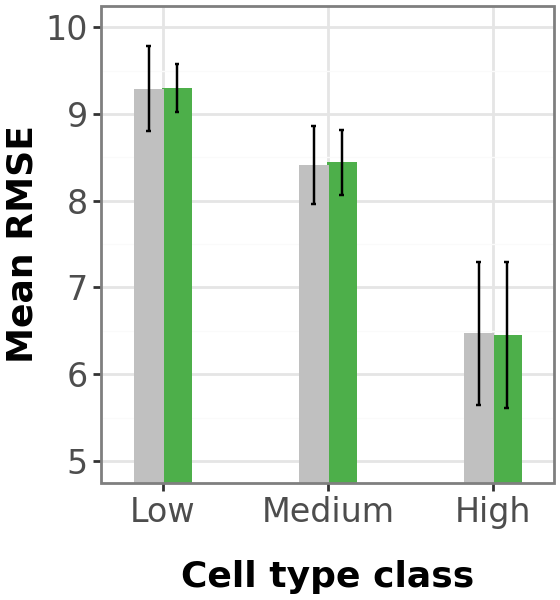

✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TS_rmse_SOTA_vs_CLADE_20251108_221741.png
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TS_rmse_SOTA_vs_CLADE_20251108_221741.svg
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TS_rmse_SOTA_vs_CLADE_20251108_221741.pdf
✅ Saved: /gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures/fig_TS_rmse_SOTA_vs_CLADE_20251108_221741.eps


In [ ]:
import pandas as pd


# === Step 1: Extract data from results ===
sota_df = exp1_results["rmse_delta_logit"][['tissue', 'rmse_delta_logit']].copy()
clade_df = exp2_results['rmse_delta_logit'][['tissue', 'rmse_delta_logit']].copy()

sota_df["Model"] = "SOTA"
clade_df["Model"] = "CLADE"

all_df = pd.concat([sota_df, clade_df], ignore_index=True)

# === Step 2: Load tissue sample class info ===
tissue_class_df = pd.read_csv(
    "/gpfs/commons/home/atalukder/Contrastive_Learning/data/TS_data/tabula_sapiens/final_data/tissue_counts_detailed_ExonBinPsi.csv"
)[["Tissue", "SampleClass"]].rename(columns={"Tissue": "tissue"})

# --- Clean merge keys ---
all_df["tissue"] = all_df["tissue"].astype(str).str.strip()
tissue_class_df["tissue"] = tissue_class_df["tissue"].astype(str).str.strip()

merged = pd.merge(all_df, tissue_class_df, on="tissue", how="inner")
# print(f"✅ Merged successfully: {merged.shape[0]} entries")

# # === Step 3: Compute mean ± std per SampleClass per Model ===
# summary = (
#     merged.groupby(["SampleClass", "Model"])["rmse_delta_logit"]
#     .agg(["mean", "std", "count"])
#     .reset_index()
# )

# # Set order for bars
# summary["SampleClass"] = pd.Categorical(summary["SampleClass"], ["Low", "Medium", "High"], ordered=True)
# --- Normalize class names ---
merged["SampleClass"] = (
    merged["SampleClass"]
    .str.replace(" sample", "", case=False)
    .str.strip()
    .str.capitalize()
)

print(f"✅ Merged successfully: {merged.shape[0]} entries")

# === Step 4: Compute mean ± std per class per model ===
summary = (
    merged.groupby(["SampleClass", "Model"])["rmse_delta_logit"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

# Ensure class order for x-axis
summary["SampleClass"] = pd.Categorical(
    summary["SampleClass"], categories=["Low", "Medium", "High"], ordered=True
)


summary["Model"] = pd.Categorical(summary["Model"], ["SOTA", "CLADE"], ordered=True)

# === Step 4: Plot ===
# p = (
#     ggplot(summary, aes(x="SampleClass", y="mean", fill="Model"))
#     + geom_bar(stat="identity", position=position_dodge(width=0.34), width=0.36)
#     + geom_errorbar(
#         aes(ymin=summary["mean"] - summary["std"], ymax=summary["mean"] + summary["std"]),
#         width=0.06, position=position_dodge(width=0.34)
#     )
#     + scale_fill_manual(values={"SOTA": "#c0c0c0", "CLADE": "#4daf4a"})  # light grey + green
#     + scale_x_discrete(expand=(0.08, 0.01))
#     + labs(
#         x="Cell type class",
#         y=r"Mean RMSE($\boldsymbol{\Delta\psi}$)",
#         fill=None
#     )
#     + theme_bw()
#     + theme(
#         figure_size=(2.8, 3.0),
#         legend_position=(0.05, 0.95),
#         legend_justification=(0, 1),
#         legend_background=element_blank(),
#         legend_title=element_blank(),
#         axis_text_x=element_text(size=12),
#         axis_text_y=element_text(size=12),
#         axis_title_x=element_text(margin={'t': 12}, size=13, weight="bold"),
#         axis_title_y=element_text(size=13, weight="bold"),
#         plot_title=element_blank()
#     )
# )


from plotnine import (
    ggplot, aes, geom_bar, geom_errorbar,
    scale_fill_manual, scale_x_discrete, scale_y_continuous,
    labs, theme_bw, theme, element_text, position_dodge, coord_cartesian
)
from plotnine.themes.elements import element_blank

p = (
    ggplot(summary, aes(x="SampleClass", y="mean", fill="Model"))
    + geom_bar(
        stat="identity",
        position=position_dodge(width=0.34),
        width=0.36
    )
    + geom_errorbar(
        aes(
            ymin=summary["mean"] - summary["std"],
            ymax=summary["mean"] + summary["std"]
        ),
        width=0.06,
        position=position_dodge(width=0.34),
        color="black"
    )
    + scale_fill_manual(values={"SOTA": "#c0c0c0", "CLADE": "#4daf4a"})
    + scale_x_discrete(expand=(0.08, 0.01))
    + coord_cartesian(ylim=(5, 10))  # ✅ preferred approach
    + labs(
        x="Cell type class",
        y=r"Mean RMSE"
    )
    + theme_bw()
    + theme(
        figure_size=(2.8, 3.0),
        legend_position='none',
        axis_text_x=element_text(size=12),
        axis_text_y=element_text(size=12),
        axis_title_x=element_text(margin={'t': 12}, size=13, weight="bold"),
        axis_title_y=element_text(size=13, weight="bold"),
        plot_title=element_blank()
    )
)



p.show()
main_dir = "/gpfs/commons/home/atalukder/Contrastive_Learning/files/RECOMB_26/figures"

out_path = f"{main_dir}/fig_TS_rmse_SOTA_vs_CLADE_{time.strftime('%Y%m%d_%H%M%S')}"
fig = p.draw()
fig.set_size_inches(2.8, 3.0)  # same as theme figure_size

formats = ['png', 'svg', 'pdf', 'eps']
for fmt in formats:
    save_path = f"{out_path}.{fmt}"
    fig.savefig(
    save_path,
    dpi=300,
    bbox_inches="tight",
    facecolor="white"
    )
    print(f"✅ Saved: {save_path}")

# === Step 5: Display & Save ===
# fig = p.draw()
# fig.set_size_inches(2.8, 3.0)
# fig.savefig("fig_rmse_SOTA_vs_CLADE.png", dpi=300, bbox_inches="tight", facecolor="white")
# plt.close(fig)
# print("📁 Saved: fig_rmse_SOTA_vs_CLADE.png")


In [13]:
import pandas as pd

# === Step 1: Load RMSE(Δlogit) results ===
exp1_rmse = exp1_results["rmse_delta_logit"]  # already a DataFrame
# e.g. columns: ["tissue", "rmse_delta_logit"]

# === Step 2: Load tissue class info ===
tissue_class_df = pd.read_csv("/gpfs/commons/home/atalukder/Contrastive_Learning/data/TS_data/tabula_sapiens/final_data/tissue_counts_detailed_ExonBinPsi.csv")[
    ["Tissue", "SampleClass"]
]

# --- Rename for merge consistency ---
tissue_class_df.rename(columns={"Tissue": "tissue", "SampleClass": "SampleClass"}, inplace=True)

# === Step 3: Merge ===
merged = pd.merge(exp1_rmse, tissue_class_df, on="tissue", how="inner")

# === Step 4: Compute per-class mean and summary ===
summary = (
    merged.groupby("SampleClass")["rmse_delta_logit"]
    .agg(["count", "mean", "std", "min", "max", "median"])
    .reset_index()
    .sort_values("mean")
)

print("📊 RMSE(Δlogit ψ) Summary by Sample Class:\n")
print(summary.to_string(index=False))

# === Optional: save to CSV ===
summary.to_csv("rmse_delta_logit_summary_by_class.csv", index=False)


📊 RMSE(Δlogit ψ) Summary by Sample Class:

  SampleClass  count     mean      std      min       max   median
  High sample     19 5.815463 0.597369 4.876626  6.945647 5.908177
Medium sample     75 8.303996 0.866517 6.482370 10.089773 8.426797
   Low sample     18 9.378010 0.568222 8.555811 10.424793 9.287275


In [14]:
import pandas as pd

# === Step 1: Load RMSE(Δlogit) results ===
exp2_rmse = exp2_results["rmse_delta_logit"]  # already a DataFrame
# e.g. columns: ["tissue", "rmse_delta_logit"]

# === Step 2: Load tissue class info ===
tissue_class_df = pd.read_csv("/gpfs/commons/home/atalukder/Contrastive_Learning/data/TS_data/tabula_sapiens/final_data/tissue_counts_detailed_ExonBinPsi.csv")[
    ["Tissue", "SampleClass"]
]

# --- Rename for merge consistency ---
tissue_class_df.rename(columns={"Tissue": "tissue", "SampleClass": "SampleClass"}, inplace=True)

# === Step 3: Merge ===
merged = pd.merge(exp2_rmse, tissue_class_df, on="tissue", how="inner")

# === Step 4: Compute per-class mean and summary ===
summary = (
    merged.groupby("SampleClass")["rmse_delta_logit"]
    .agg(["count", "mean", "std", "min", "max", "median"])
    .reset_index()
    .sort_values("mean")
)

print("📊 RMSE(Δlogit ψ) Summary by Sample Class:\n")
print(summary.to_string(index=False))

# === Optional: save to CSV ===
summary.to_csv("rmse_delta_logit_summary_by_class.csv", index=False)


📊 RMSE(Δlogit ψ) Summary by Sample Class:

  SampleClass  count     mean      std      min      max   median
  High sample     19 5.778404 0.547602 4.966589 6.803893 5.754895
Medium sample     75 8.300470 0.830001 6.304551 9.543291 8.418124
   Low sample     18 9.455383 0.277410 9.109099 9.963894 9.375162



--- Generating Plot Setting 2: TS_noCL_300bp_rerun_codeChange_ensembled vs TS_CLSwpd_300bp_10Aug_ensembled ---
Figure saved to: /gpfs/commons/home/atalukder/Contrastive_Learning/code/ML_model/figures/setting2_rmse_delta_logit_TS_noCL_300bp_rerun_codeChange_ensembled_vs_TS_CLSwpd_300bp_10Aug_ensembled_2025_11_13__01_07_41.png


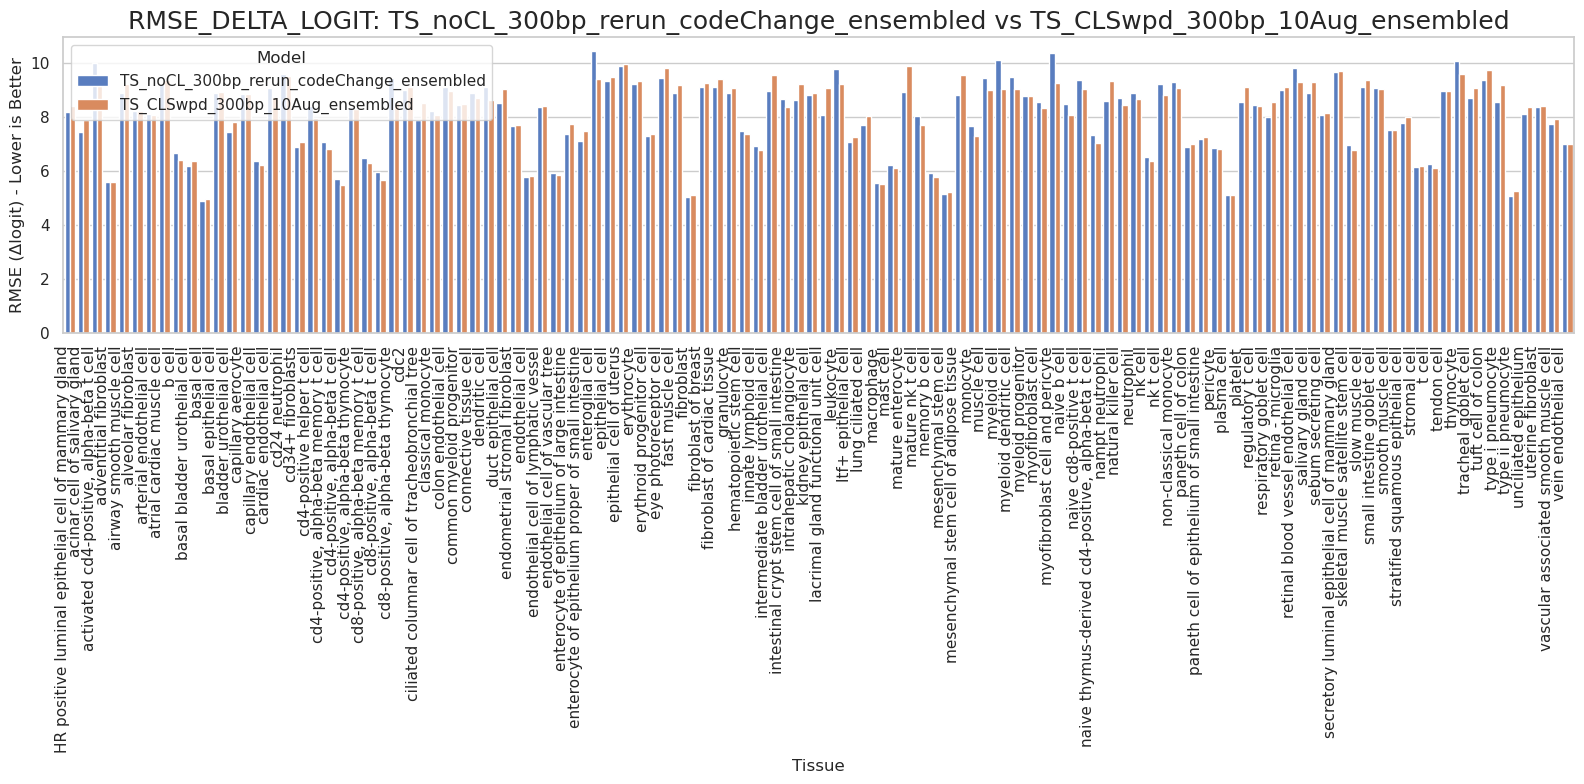

Figure saved to: /gpfs/commons/home/atalukder/Contrastive_Learning/code/ML_model/figures/setting2_rmse_psi_TS_noCL_300bp_rerun_codeChange_ensembled_vs_TS_CLSwpd_300bp_10Aug_ensembled_2025_11_13__01_07_41.png


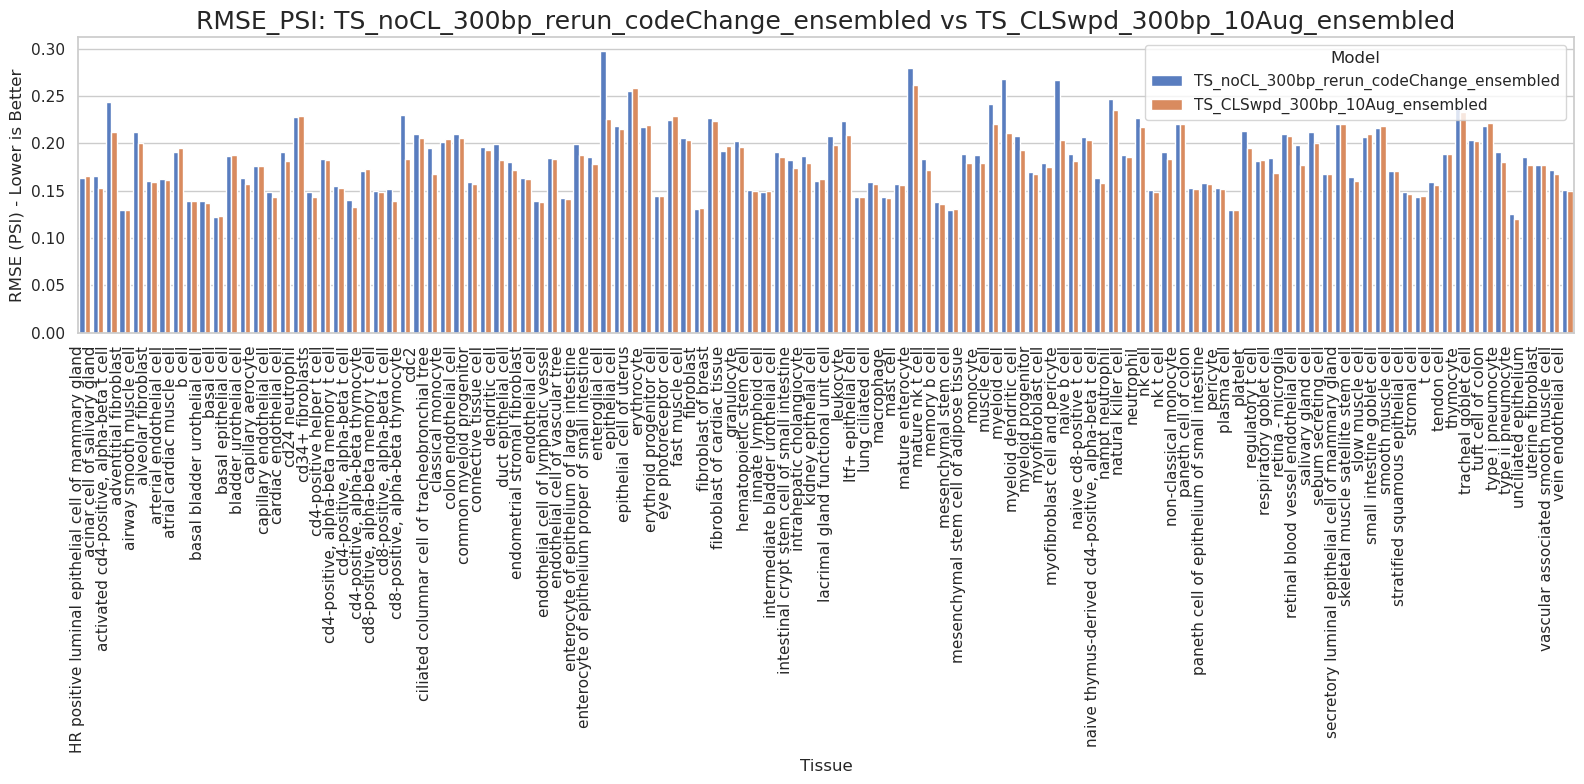

In [15]:
# %%
#################################################################
# --- Plotting Setting 2: User (Exp 1) vs. User (Exp 2) ---
#################################################################
print(f"\n--- Generating Plot Setting 2: {model1_name} vs {model2_name} ---")

# --- Choose your metric ---
# Options: 'rmse_psi', 'rmse_delta_psi', 'rmse_delta_logit'
metric_to_plot_2 = 'rmse_delta_logit'
# --------------------------

title_2 = f"{metric_to_plot_2.upper()}: {model1_name} vs {model2_name}"
save_name_2 = f"setting2_{metric_to_plot_2}_{model1_name}_vs_{model2_name}"

generate_comparison_plot(
    title_2,
    save_name_2,
    (exp1_results[metric_to_plot_2], metric_to_plot_2, exp1_results['name']),
    (exp2_results[metric_to_plot_2], metric_to_plot_2, exp2_results['name'])
)

# --- (Optional) Plot another metric from this setting ---
metric_to_plot_2b = 'rmse_psi'
title_2b = f"{metric_to_plot_2b.upper()}: {model1_name} vs {model2_name}"
save_name_2b = f"setting2_{metric_to_plot_2b}_{model1_name}_vs_{model2_name}"

generate_comparison_plot(
    title_2b,
    save_name_2b,
    (exp1_results[metric_to_plot_2b], metric_to_plot_2b, exp1_results['name']),
    (exp2_results[metric_to_plot_2b], metric_to_plot_2b, exp2_results['name'])
)

In [16]:
def plot_average_across_tissues_2models(
    df1, df2, model1_name, model2_name,
    metric, save_path=None, palette=None
):
    """
    Compute and plot the average metric across all tissues for 2 models.
    Works directly with the structure used in your current code:
    exp1_results[metric] and exp2_results[metric].

    Args:
        df1, df2: Can be either pandas Series (e.g. exp1_results[metric])
                  or DataFrames containing the metric column.
        model1_name, model2_name: str, model names for labeling.
        metric: str, metric name (e.g. 'rmse_delta_logit').
        save_path: optional path to save figure.
        palette: optional seaborn palette.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # --- Handle both Series and DataFrame inputs gracefully ---
    if isinstance(df1, pd.DataFrame):
        values1 = df1[metric]
    else:
        values1 = df1

    if isinstance(df2, pd.DataFrame):
        values2 = df2[metric]
    else:
        values2 = df2

    # --- Compute average values ---
    avg_df = pd.DataFrame({
        'Model': [model1_name, model2_name],
        'Average': [values1.mean(), values2.mean()]
    }).round(4)

    # --- Set color palette ---
    if palette is None:
        palette = sns.color_palette("viridis", n_colors=2)

    # --- Dynamic y-axis range ---
    y_min = max(0, avg_df["Average"].min() - 0.05)
    y_max = avg_df["Average"].max() + 0.05

    # --- Plot ---
    plt.figure(figsize=(5, 4))
    ax = sns.barplot(data=avg_df, x='Model', y='Average', palette=palette, width=0.5)
    for i, row in avg_df.iterrows():
        ax.text(i, row["Average"] + 0.01, f"{row['Average']:.3f}",
                ha='center', va='bottom', fontsize=9, fontweight='medium')

    plt.ylabel(f"Average {metric.replace('_', ' ').title()}")
    plt.title(f"Average {metric.replace('_', ' ').title()} Across All Tissues", fontsize=11)
    plt.ylim(y_min, y_max)
    plt.xticks(rotation=15, ha='right')
    plt.tight_layout()

    # --- Save & return ---
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"✅ Saved average plot → {save_path}")

    plt.show()
    return avg_df


/scratch/ipykernel_732909/1270571548.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=avg_df, x='Model', y='Average', palette=palette, width=0.5)


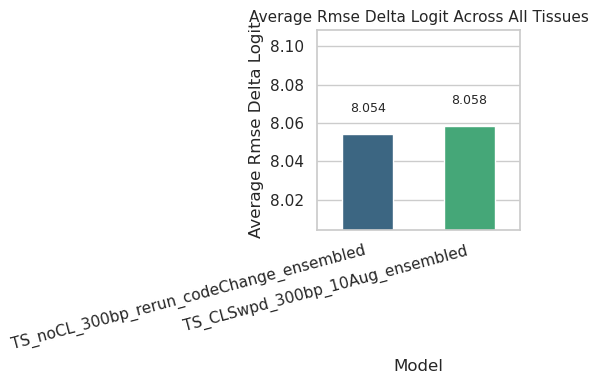

/scratch/ipykernel_732909/1270571548.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=avg_df, x='Model', y='Average', palette=palette, width=0.5)


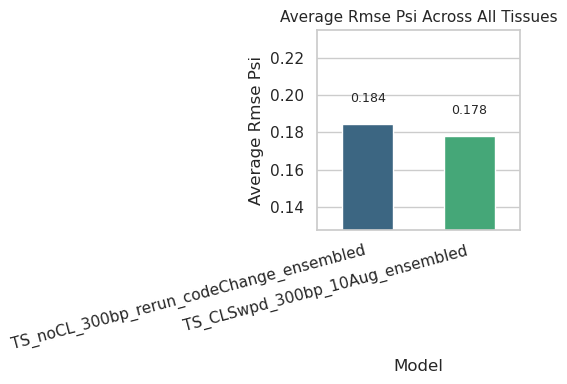

In [17]:
avg_df = plot_average_across_tissues_2models(
    df1=exp1_results[metric_to_plot_2],
    df2=exp2_results[metric_to_plot_2],
    model1_name=model1_name,
    model2_name=model2_name,
    metric=metric_to_plot_2,
)


avg_df = plot_average_across_tissues_2models(
    df1=exp1_results[metric_to_plot_2b],
    df2=exp2_results[metric_to_plot_2b],
    model1_name=model1_name,
    model2_name=model2_name,
    metric=metric_to_plot_2b,
)

In [ ]:
import pandas as pd
import numpy as np

def get_stratified_average_1model(
    model_results_df,
    imbalance_file_path,
    metric,
    low_lim,
    high_lim,
    model_name="Model"
):
    """
    Calculates the average of a metric for a SINGLE model,
    stratified by the "Up" vs. "Down" imbalance categories.

    Args:
        model_results_df (pd.DataFrame): 
            DataFrame with per-tissue metrics. Must contain 'tissue' and the 'metric' column.
        imbalance_file_path (str):
            Path to the CSV file containing 'tissue' and 'percent_up' columns.
        metric (str):
            The name of the metric column to average (e.g., 'f1').
        model_name (str):
            A name for the model, used for the output DataFrame.
            
    Returns:
        pd.DataFrame: A DataFrame with the average metric for each category.
    """
    
    # --- 1. Load Imbalance Data ---
    try:
        imbalance_df = pd.read_csv(imbalance_file_path)
    except FileNotFoundError:
        print(f"Error: Imbalance file not found at {imbalance_file_path}")
        return pd.DataFrame()

    # --- 2. Define Binning Logic ---
    def categorize_imbalance(percent_up):
        if pd.isna(percent_up):
            return "N/A"
        # Using the bins we found worked best:
        if percent_up < low_lim:
            return f"1. Slightly Down-Heavy (< {low_lim})"
        elif low_lim <= percent_up <= high_lim:
            return f"2. Highly Balanced ({low_lim} - {high_lim})"
        else: # percent_up > 0.55
            return f"3. Slightly Up-Heavy (> {high_lim})"

    imbalance_df['granular_category'] = imbalance_df['percent_up'].apply(categorize_imbalance)

    # --- 3. Merge Data ---
    # We only need the tissue and category from the imbalance data
    imbalance_categories = imbalance_df[['tissue', 'granular_category']]
    
    # Merge with the model's results
    merged_df = model_results_df.merge(imbalance_categories, on="tissue")
    
    if merged_df.empty:
        print(f"Error: No tissues matched between results and imbalance file.")
        return pd.DataFrame()
        
    if metric not in merged_df.columns:
        print(f"Error: Metric '{metric}' not found in the results DataFrame.")
        return pd.DataFrame()

    # --- 4. Calculate Stratified Average ---
    stratified_avg = merged_df.groupby('granular_category')[metric].mean().reset_index()
    
    # Rename columns for clarity
    stratified_avg = stratified_avg.rename(columns={metric: f'average_{metric}'})
    stratified_avg['model'] = model_name
    
    # Set category as index for clean printing
    return stratified_avg.set_index('granular_category')

In [ ]:
# (Assuming your dataframes and names are already loaded)
# exp1_results, model1_name
# root_path, division

# --- 1. Define file paths and metric ---
imbalance_file = f"/gpfs/commons/home/atalukder/Contrastive_Learning/data/TS_data/tabula_sapiens/final_data/test_upDown_imbalance.csv"
low_lim = 0.15
high_lim = 0.25
metric_to_calc = 'rmse_delta_logit'

# --- 2. Run the function for just model 1 ---
stratified_model1_df = get_stratified_average_1model(
    exp1_results[metric_to_calc],
    imbalance_file_path=imbalance_file,
    metric=metric_to_calc,
    low_lim=low_lim,
    high_lim=high_lim,
    model_name=model1_name
)

# --- 3. Print the results ---
print(f"\nStratified {metric_to_calc} (Up vs. Down) for {model1_name}:")
print(stratified_model1_df)


# --- 2. Run the function for just model 1 ---
stratified_model2_df = get_stratified_average_1model(
    exp2_results[metric_to_calc],
    imbalance_file_path=imbalance_file,
    metric=metric_to_calc,
    low_lim=low_lim,
    high_lim=high_lim,
    model_name=model2_name
)

# --- 3. Print the results ---
print(f"\nStratified {metric_to_calc} (Up vs. Down) for {model2_name}:")
print(stratified_model2_df)

In [ ]:

metric_to_calc = 'rmse_psi' # or 'auprc', 'spearman_rho_delta_psi', etc.

# --- 2. Run the function for just model 1 ---
stratified_model1_df = get_stratified_average_1model(
    exp1_results[metric_to_calc],
    imbalance_file_path=imbalance_file,
    metric=metric_to_calc,
    low_lim=low_lim,
    high_lim=high_lim,
    model_name=model1_name
)

# --- 3. Print the results ---
print(f"\nStratified {metric_to_calc} (Up vs. Down) for {model1_name}:")
print(stratified_model1_df)


# --- 2. Run the function for just model 1 ---
stratified_model2_df = get_stratified_average_1model(
    exp2_results[metric_to_calc],
    imbalance_file_path=imbalance_file,
    metric=metric_to_calc,
    low_lim=low_lim,
    high_lim=high_lim,
    model_name=model2_name
)

# --- 3. Print the results ---
print(f"\nStratified {metric_to_calc} (Up vs. Down) for {model2_name}:")
print(stratified_model2_df)